# Notebook 3: Multifactor Risk Model Estimation & Forecasting

### **Objective**
The objective of this notebook is to construct a **dynamic multifactor risk model**. This process is divided into two major phases: **historical estimation** and **forward-looking forecasting**. We move beyond a simple historical risk model to create a more adaptive and robust forecast of the core risk components: the **Factor Covariance Matrix ($F$)** and the **Specific Risk Matrix ($\Delta$)**.

The final output of this notebook is a set of calibrated forecasting models that can generate a point-in-time forecast for the total covariance matrix, $V_{t+1}$, using the fundamental equation:
$$ V_{t+1} = X_t \ F_{t+1} \ X_t^T + \Delta_{t+1} $$

---

### **Methodology & Pipeline**

Our methodology is a multi-stage process that reflects professional practice in quantitative risk management.

#### **Phase 1: Historical Estimation (Fama-MacBeth)**

First, we must generate a historical time series of the unobservable factor and specific returns.

*   **1. Cross-Sectional Regressions:** We implement the **Fama-MacBeth procedure**, iterating through each month ($t$) in our historical sample. For each month, we run a single, large **Weighted Least Squares (WLS)** cross-sectional regression of stock returns against their known factor exposures.
    $$ r(t) = X(t)b(t) + u(t) $$
    This regression generates the crucial historical inputs for our forecasting models:
    *   $\hat{b}(t)$: The time series of estimated **factor returns**.
    *   $\hat{u}(t)$: The time series of estimated **specific (residual) returns**.

#### **Phase 2: Forward-Looking Forecasting**

A simple historical average of risk is not a good forecast. We build dedicated forecasting models for each component of risk, as described in Grinold & Kahn.

*   **2. Forecasting the Factor Covariance Matrix ($F_{t+1}$):**
    We model the time-varying nature of factor volatilities and correlations. For this project, we implement an **Exponentially Weighted Moving Average (EWMA)** model. This approach gives more weight to recent observations, allowing the risk forecast to adapt to changing market regimes. The forecast for the next period is an update of the previous forecast based on the most recent factor return observation:
    $$ F_{t+1} = \lambda \cdot F_t + (1-\lambda) \cdot (b_t b_t^T) $$

*   **3. Forecasting the Specific Risk Matrix ($\Delta_{t+1}$):**
    We decompose specific risk into two components: a market-wide average and a firm-specific deviation.
    $$ \sigma_{u,n}^2(t) = S(t) \cdot [1 + v_n(t)] $$
    *   **The "Tide" ($S(t)$):** The average specific variance across all stocks. We model this using a univariate time-series model (e.g., another EWMA or GARCH model) to capture its persistence and volatility clustering.
    *   **The "Wave" ($v_n(t)$):** The firm's deviation from the average. We model this using a **pooled cross-sectional regression**, forecasting a firm's relative specific risk based on its current characteristics (e.g., its Size, recent volatility).
    The final forecast, $\Delta_{t+1}$, is a diagonal matrix of the combined forecasts for each stock.

---

### **Key Concepts & Theoretical Justification**

#### **1. Time-Varying Risk**

A core principle of modern risk management is that risk is not static. Volatility and correlations change over time, often clustering in regimes. Simple historical models fail to capture this. By using dynamic forecasting techniques like **EWMA or GARCH**, our risk model becomes more adaptive and produces more realistic forecasts, especially during periods of market stress.

#### **2. Structural Specific Risk Forecasting**

A stock's specific risk is also not random; it is related to its fundamental characteristics. The two-part (`S(t)` and `v_n(t)`) model is a powerful innovation. It separates the systematic, market-wide component of specific risk (the "tide") from the firm-specific component (the "wave"). This allows us to create more accurate and granular forecasts than a simple historical volatility calculation for each stock. By using a **pooled regression** to model `v_n(t)`, we leverage the entire cross-section of thousands of firms to learn the stable, long-run relationships between characteristics like Size and specific risk.

---
**Output:** This notebook produces two calibrated forecasting "machines" for $F$ and $\Delta$. These machines are then used to generate the final, one-period-ahead forecasts, `F_forecast` and `Delta_forecast`, which are the essential inputs for the portfolio construction process in Notebook 5.

### 1. Imports and Load Data

In [73]:
import pandas as pd 
import os 
from pathlib import Path 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
print('Libraries imported succesfully')

Libraries imported succesfully


In [74]:
onedrive_root = str(Path(os.environ['OneDrive']))
DATA_DIR = os.path.join(onedrive_root, '0. DATASETS', 'outputs')

# Defining file paths fpr the panel data from notebook 1 and 
# Factor exposures from notebook 2 and import files
PANEL_DATA_FILE = os.path.join(DATA_DIR, 'panel_data.parquet')
FACTOR_EXPOSURES_FILE = os.path.join(DATA_DIR, 'factor_exposures.parquet')

panel_data = pd.read_parquet(PANEL_DATA_FILE)
# Making sure permno is type int.
panel_data['permno'] = panel_data['permno'].astype('int')
panel_data.reset_index(inplace = True)
panel_data.set_index(['permno', 'date'], inplace = True)

X = pd.read_parquet(FACTOR_EXPOSURES_FILE)
X.reset_index(inplace = True)
X.set_index(['permno', 'date'], inplace = True)

# For best practice, making sure the two dataframes align perfectly
panel_data, X = panel_data.align(X, join = 'inner', axis = 0)

### 2. The Fama-McBeth Monthly Cross-Sectional Regressions

In [75]:
# Each month, we regress returns on factor exposures
# r (N x 1) = X (N x K) . b (K x 1) + u (N x 1)
# Defining the dependant variable in the FM regression 
Y = panel_data['ret_monthly']
X_sm = sm.add_constant(X).astype(float)

# Creating empty lists for historical monthly factor returns and
# one historical monthly  resdiauls 
b_history = []
u_history = []

# cross section month ends to loop over for FM regressions
unique_dates = panel_data.index.get_level_values(1).drop_duplicates().sort_values().tolist()

# add a counter for progress
num_dates = len(unique_dates)
print(f"Starting Fama-MacBeth regressions for {num_dates} months...")

for i, month in enumerate(unique_dates):
    # -- print progress every 12 months --
    if (i+1) % 12 == 0 :
        print(f" ... processing month {i+1} of {num_dates} ({month.strftime('%Y-%m')})")
    # extract the monthly cross sections and weights 
    y_month = Y.xs(month, level = 1)
    x_month = X_sm.xs(month, level = 1)
    w_month = panel_data['mkt_cap'].xs(month, level = 1 )
    
    # --- Robustness Check for NaN Values: Align all inputs and drop NaNs ---
    # Combine into a temporary DataFrame
    temp_df = pd.concat([y_month, x_month, w_month], 
                        axis = 1, 
                        keys = ['ret', 'factors', 'weight'])
    temp_df.dropna(inplace= True)
    if len(temp_df) > x_month.shape[1]: # we need more observations than RHS variables 
        y_clean = temp_df['ret']
        x_clean = temp_df['factors']
        w_clean = temp_df['weight']

        sm_wls = sm.WLS(endog = y_month, 
                        exog = x_month,
                        weights = w_month).fit()
        
        b_history.append(pd.Series(sm_wls.params, name = month)) # after the loop, b_history will be a list of series each containing factor returns for the month
        u_history.append(pd.Series(sm_wls.resid.reindex(x_month.index), name = month)) # after the loop, u_history will be a list of series each containing residual returns for all stocks for the month
print("\nFama-MacBeth regressions complete.")

# Assemble and Clean Historical DataFrames
# Creating Historical Factor Returns from b_history (T x K dimensions)
factor_returns = pd.DataFrame(b_history).drop(columns = ['const'])
factor_returns.index.name = 'date'

# Creating Historical Specific Returns from b_history  (T x N dimensions)
specific_returns = pd.DataFrame(u_history)
specific_returns.index.name = 'date'

Starting Fama-MacBeth regressions for 343 months...
 ... processing month 12 of 343 (1996-05)
 ... processing month 24 of 343 (1997-05)
 ... processing month 36 of 343 (1998-05)
 ... processing month 48 of 343 (1999-05)
 ... processing month 60 of 343 (2000-05)
 ... processing month 72 of 343 (2001-05)
 ... processing month 84 of 343 (2002-05)
 ... processing month 96 of 343 (2003-05)
 ... processing month 108 of 343 (2004-05)
 ... processing month 120 of 343 (2005-05)
 ... processing month 132 of 343 (2006-05)
 ... processing month 144 of 343 (2007-05)
 ... processing month 156 of 343 (2008-05)
 ... processing month 168 of 343 (2009-05)
 ... processing month 180 of 343 (2010-05)
 ... processing month 192 of 343 (2011-05)
 ... processing month 204 of 343 (2012-05)
 ... processing month 216 of 343 (2013-05)
 ... processing month 228 of 343 (2014-05)
 ... processing month 240 of 343 (2015-05)
 ... processing month 252 of 343 (2016-05)
 ... processing month 264 of 343 (2017-05)
 ... proce

### 3. Decompose and Model Specific Risk 
The objective is to implement the sophisticated two-part specific risk forecast described in the G&K book.
We will:
Decompose the historical specific variances into a "tide" (S(t)) and a "wave" (v_n(t)).
Build a simple forecasting model for the "tide."
Build a simple forecasting model for the "wave."
Combine them to create our final, one-step-ahead forecast for the Δ matrix.

#### 3.1 Calculate and Winsorize historical specific variances

In [76]:
# Calculate Historical Specific Variances
squared_residuals = specific_returns ** 2

# --- Robust Outlier Handling: Winsorization ---
# To prevent a single extreme event (like GME) from dominating our model,
# we will cap all specific variances at the global 99th percentile.

# First, find the single 99th percentile value across ALL observations in the entire DataFrame.
# .unstack() converts the DataFrame into a single long Series.
global_p99 = squared_residuals.unstack().quantile(0.99)
print(f"Global 99th percentile for squared specific returns: {global_p99:.6f}")

# Now, cap any value in the DataFrame that is above this threshold.
winsorized_squared_residuals = squared_residuals.clip(upper=global_p99)

print("Squared specific returns have been winsorized.")


Global 99th percentile for squared specific returns: 0.294108
Squared specific returns have been winsorized.


#### Decomposing into "Tide and Wave"

#### 3.2 The Tide S(t)

In [77]:
# --- Decomposing into "Tide" and "Wave" ---

# Calculate the Tide (S(t)): The cross-sectional average of the WINSORIZED specific variances.
s_t = winsorized_squared_residuals.mean(axis=1)

# Calculate the Wave (v_n(t)): The deviation from the tide for each stock-month.
v_nt = winsorized_squared_residuals.div(s_t, axis=0) - 1

print("\nSpecific risk decomposed into 'Tide' (S_t) and 'Wave' (v_nt).")
print("\nHistorical Tide (S_t) Head:")
print(s_t.head())
print("\nHistorical Wave (v_nt) Head:")
print(v_nt.head())

# create a smoothed/forecasted version of the tide using exponential moving averages
s_t_ewm = s_t.ewm(alpha = 0.3, adjust = False).mean()


Specific risk decomposed into 'Tide' (S_t) and 'Wave' (v_nt).

Historical Tide (S_t) Head:
date
1995-06-30    0.011125
1995-07-31    0.015788
1995-08-31    0.014688
1995-09-30    0.012135
1995-10-31    0.014677
dtype: float64

Historical Wave (v_nt) Head:
permno         10001     10002     10009     10010     10016     10019  \
date                                                                     
1995-06-30 -0.950101 -0.562260 -0.841663 -0.803802 -0.983040 -0.784370   
1995-07-31 -0.927457       NaN       NaN       NaN -0.432105  2.177758   
1995-08-31 -0.564279 -0.401662 -0.564619  1.465736  2.853113 -0.413436   
1995-09-30 -0.953434  0.048841 -0.993142       NaN -0.890177 -0.219474   
1995-10-31 -0.999931 -0.628787 -0.991485       NaN -0.943082 -0.706012   

permno         10025     10026     10028     10035  ...  23352  23372  23426  \
date                                                ...                        
1995-06-30  1.539633 -0.987950  5.400716 -0.942513  ...    NaN  

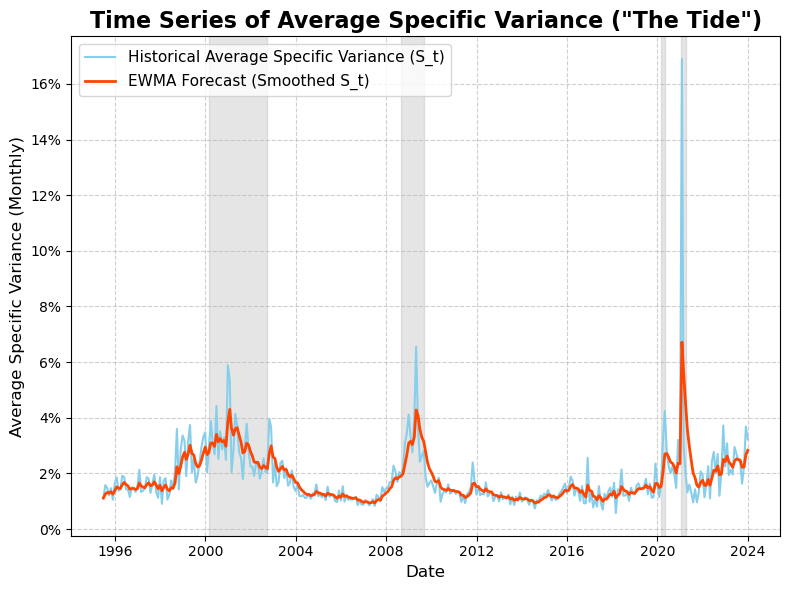

The one-step-ahead forecast for S(t+1) is: 2.8327%


In [78]:
# --- Visualizing Historical Average Specific Variance (S_t) ---

# 1. Setting up the Plot
fig, ax = plt.subplots(figsize=(8, 6)) # Creating a figure and axes object

# 2. Plotting the Data
ax.plot(s_t, label='Historical Average Specific Variance (S_t)', color='skyblue', linewidth=1.5)
ax.plot(s_t_ewm, label='EWMA Forecast (Smoothed S_t)', color='orangered', linewidth=2.0)

# 3. Adding Shaded Regions for Crises
# We define the start and end dates for major volatility events
crisis_periods = {
    'Dot-com Bubble': ('2000-03-01', '2002-10-01'),
    'Global Financial Crisis': ('2008-09-01', '2009-09-01'),
    'COVID-19 Crash': ('2020-03-01', '2020-05-01'),
    'The Meme Stock Saga' :('2021-01-15', '2021-04-01')
}

for name, (start, end) in crisis_periods.items():
    ax.axvspan(start, end, color='grey', alpha=0.2, label=f'_{name}') 

# 4. Adding Labels, Title, and Grid
ax.set_title('Time Series of Average Specific Variance ("The Tide")', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Average Specific Variance (Monthly)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

# 5. Formatting the Axes
# Making the y-axis a percentage for easier reading
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

# Ensuring the plot looks clean
plt.tight_layout()

# 6. Saving the Figure
fig.savefig('images/specific_risk_tide.png', dpi=300) 

# 7. Showing the Plot
plt.show()

# --- The Final Forecast ---
s_forecast = s_t_ewm.iloc[-1]
print(f"The one-step-ahead forecast for S(t+1) is: {s_forecast:.4%}")


#### 3.3 Build the Wave v_n(t) Forecasting Model (Pooled Regression) 

In [79]:
print("Building the 'Wave' (v_n) forecasting model...")

# Our 'Y' variable is the v_nt DataFrame
# need to reshape our T x N v_nt DataFrame into a long (T*N) x 1 Series for the regression.
y_v = v_nt.unstack()
y_v.index.rename(['permno', 'date'], inplace = True)
y_v.rename('v_nt', inplace = True)

# Our 'X' variables are the factor exposures from Notebook 2 loaded earlier
x_v = X.copy()

y_v.sort_index(inplace=True)
x_v.sort_index(inplace=True)

# Join the Y and X data together
# This ensures our y and X variables are perfectly aligned before the regression.
regression_df = y_v.to_frame().join(x_v)
regression_df.dropna(inplace= True) # Drop any rows with missing data

# 2. Define the regression variables
y_v_clean = regression_df['v_nt']
# We'll use our style factors as predictors. We add a constant for the intercept.
x_v_clean = sm.add_constant(regression_df[['Size', 'Value', 'Momentum', 'FinConstraint']])

# 3. Run the Pooled OLS Regression
# This single regression uses all (N*T) observations.
pooled_ols_model = sm.OLS(y_v_clean, 
                          x_v_clean).fit()

# 4. Analyze the Results
print("\n--- Pooled Regression Results for v_n(t) ---")
print(pooled_ols_model.summary())

# Store the coefficients (our gamma vector)
gamma_coeffs = pooled_ols_model.params

# 5. Make the Forward-Looking Forecast for the Wave
# To forecast v_n for the next period (T+1), we use our gamma coefficients
# and the most recent factor exposures (from the last row of our X matrix)
X_latest = sm.add_constant(X.xs(X.index.get_level_values('date').max(), 
                                level = 1)[['Size', 'Value', 'Momentum', 'FinConstraint']])

# The forecast is simply the dot product of the latest exposures and the gamma coefficients
# It's an Nx1 vector containing each stocks period T+1 Wave component of its specific risk 
v_forecast = X_latest @ gamma_coeffs
v_forecast.name = 'v_forecast'

print("\nForecast for the next period's 'Wave' (v_n, T+1):")
print(v_forecast.head())

Building the 'Wave' (v_n) forecasting model...



--- Pooled Regression Results for v_n(t) ---
                            OLS Regression Results                            
Dep. Variable:                   v_nt   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                 1.914e+04
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:59:54   Log-Likelihood:            -2.3091e+06
No. Observations:             1030177   AIC:                         4.618e+06
Df Residuals:                 1030172   BIC:                         4.618e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


### 4. Assemble the Δ_forecast
Creating the final, N x N diagonal matrix of forecasted specific variances for the period T+1. 

*σ̂_u,n²(T+1) = Ŝ(T+1) * (1 + v̂_n(T+1))*

We have already calculated the two necessary ingredients:

**s_forecast**: This is our one-step-ahead forecast for the *"Tide"* (Ŝ(T+1)) a single scalar number.

**v_forecast**: This is our N x 1 Series of one-step-ahead forecasts for the *"Wave"* (v̂_n(T+1)).

In [80]:
# --- Assemble the Final Delta Forecast ---

# 1. Handle potential negative variance forecasts
print(f"Checking for extreme negative forecasts in v_forecast...")
num_clipped = np.sum(v_forecast < -1)
if num_clipped > 0:
    print(f"  WARNING: Found {num_clipped} forecasts for 'v' less than -1. Clipping them to -1.")
    v_forecast_clipped = v_forecast.clip(lower=-1)
else:
    print("  No extreme negative forecasts found. Good.")
    v_forecast_clipped = v_forecast

# 2. Combining the "Tide" and "Wave" forecasts (G&K equation 3A.5)
# This is our final vector of specific variance forecasts
final_specific_variances = s_forecast * (v_forecast_clipped + 1)
final_specific_variances.name = 'specific_variance_forecast'

print("\nFinal specific variance forecasts calculated.")

# 3. Creating the full Delta_forecast matrix 
print("Constructing the full diagonal Delta matrix...")
Delta_forecast = pd.DataFrame(np.diag(final_specific_variances),
                              index=final_specific_variances.index,
                              columns=final_specific_variances.index)
print("Delta_forecast matrix created successfully.")


# 4. Save the key output for the next notebook
# We only need to save the vector of variances, not the full sparse matrix.
DELTA_FORECAST_FILE = os.path.join(DATA_DIR, 'specific_variances_forecast.parquet')
final_specific_variances.to_frame().to_parquet(DELTA_FORECAST_FILE)

print(f"\nSpecific variance forecasts saved to {DELTA_FORECAST_FILE}")


Checking for extreme negative forecasts in v_forecast...

Final specific variance forecasts calculated.
Constructing the full diagonal Delta matrix...
Delta_forecast matrix created successfully.

Specific variance forecasts saved to D:\OneDrive\0. DATASETS\outputs\specific_variances_forecast.parquet


### 5. Assemble the Total Covariance Forecast (V_forecast)

In [83]:
# --- FINAL STAGE: Assemble the Forward-Looking Risk Model ---

# In this final stage, we will take all the components we have built and
# assemble the one-period-ahead forecast for the total covariance matrix, V.

print("--- Assembling the Final V_forecast Matrix ---")

# --- 1. Forecast the Factor Covariance Matrix (F) ---

# Define our smoothing factor for the EWMA
ewma_alpha = 0.3

# Calculate the exponentially weighted covariance matrix series
ewm_cov_series = factor_returns.ewm(alpha=ewma_alpha, adjust=False).cov()

# Our forecast for the next period is the last matrix in this series
last_date = ewm_cov_series.index.get_level_values('date').max()
F_forecast = ewm_cov_series.loc[last_date]

print("Step 1: F_forecast matrix created successfully.")


# --- 2. Prepare the Latest X and Delta Matrices ---

# Get the most recent cross-section of Factor Exposures (X)
X_latest = X.xs(X.index.get_level_values('date').max(), level = 1)

print("Step 2: Latest X and Delta matrices are ready.")


# --- 3. Align all components (The Critical Safety Check) ---
print("\nStep 3: Aligning all matrix dimensions...")

# Find the intersection of stocks that exist in all our data
common_stocks = X_latest.index.intersection(Delta_forecast.index)

# Find the intersection of factors (ensuring 'const' is excluded)
common_factors = X_latest.columns.intersection(F_forecast.index)

# Filter all matrices to this common, aligned universe
X_aligned = X_latest.loc[common_stocks, common_factors]
F_aligned = F_forecast.loc[common_factors, common_factors]
Delta_aligned = Delta_forecast.loc[common_stocks, common_stocks]

# --- Sanity Check: Print the shapes of the aligned matrices ---
print(f"  Shape of X_aligned: {X_aligned.shape}")
print(f"  Shape of F_aligned: {F_aligned.shape}")
print(f"  Shape of Delta_aligned: {Delta_aligned.shape}")
print("Alignment complete.")


# --- 4. Assemble the final V matrix using the master formula ---
print("\nStep 4: Calculating V_forecast = X * F * X^T + Delta...")

V_forecast = X_aligned @ F_aligned @ X_aligned.T + Delta_aligned

print(f"Final V_forecast matrix created successfully. Shape: {V_forecast.shape}")


# --- 5. Save the final risk model output ---
V_FORECAST_FILE = os.path.join(DATA_DIR, 'total_covariance_forecast.parquet')
V_forecast.to_parquet(V_FORECAST_FILE)

print(f"\nSaved final risk model to: {V_FORECAST_FILE}")
print("--- Notebook 3 (Project Titan) is Complete ---")

# Display a sample of the final covariance matrix
print("\nSample of the final V_forecast matrix (top 5x5):")
print(V_forecast.iloc[:5, :5])

--- Assembling the Final V_forecast Matrix ---
Step 1: F_forecast matrix created successfully.
Step 2: Latest X and Delta matrices are ready.

Step 3: Aligning all matrix dimensions...
  Shape of X_aligned: (3275, 16)
  Shape of F_aligned: (16, 16)
  Shape of Delta_aligned: (3275, 3275)
Alignment complete.

Step 4: Calculating V_forecast = X * F * X^T + Delta...
Final V_forecast matrix created successfully. Shape: (3275, 3275)

Saved final risk model to: D:\OneDrive\0. DATASETS\outputs\total_covariance_forecast.parquet
--- Notebook 3 (Project Titan) is Complete ---

Sample of the final V_forecast matrix (top 5x5):
permno     10026     10028     10032     10044     10066
permno                                                  
10026   0.025022  0.002185  0.001245  0.002103  0.002499
10028   0.002185  0.049337  0.004033  0.006022  0.007842
10032   0.001245  0.004033  0.027309   0.00377  0.005597
10044   0.002103  0.006022   0.00377  0.058878  0.007259
10066   0.002499  0.007842  0.005597